


#**Preparazione ambiente**




In [1]:
# importo elementi necessari

# Dataset di features e scaler
!wget https://www.dropbox.com/s/knjdypt0x3nnz5g/Best_data.zip
!unzip Best_data.zip

# Imagini di test
!wget https://www.dropbox.com/s/192gvq2wltgw4in/test_images.zip
!unzip test_images.zip

--2021-02-04 21:40:04--  https://www.dropbox.com/s/knjdypt0x3nnz5g/Best_data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/knjdypt0x3nnz5g/Best_data.zip [following]
--2021-02-04 21:40:05--  https://www.dropbox.com/s/raw/knjdypt0x3nnz5g/Best_data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc15b29eee14fadfa711578a797f.dl.dropboxusercontent.com/cd/0/inline/BIVxbLF9beCsaPEcli03XAwj-ecOhu3CdgKAQj0cTDqnkj0Enc_vRPGMyaA5x4xNMldCUAiUF9gSpt-k0xdzjVOXzf0UDSMZhsFyEVIzkHXaplj3fzX8bwU55DlnhkXK94w/file# [following]
--2021-02-04 21:40:05--  https://uc15b29eee14fadfa711578a797f.dl.dropboxusercontent.com/cd/0/inline/BIVxbLF9beCsaPEcli03XAwj-ecOhu3CdgKAQj0cTDqnkj0Enc_vRPGMyaA5x4xNMldCUAiUF9gSpt-k0xdzjVOXzf0UDSMZhsFyEVIzkHXa

In [2]:
import numpy as np
from numpy import save
import pickle
import cv2
import os
import glob
import time
from time import sleep
import matplotlib
from matplotlib import pyplot as plt
import imutils
from imutils import paths
from imutils.object_detection import non_max_suppression
from skimage.feature import hog
from skimage import data, exposure
from skimage.transform import pyramid_gaussian
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn import decomposition
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from IPython.display import HTML, display
from google.colab.patches import cv2_imshow
#enable_colab()

---

#**Analisi preliminare  dei dati**

In [3]:
def data_analize(train_sample,train_label,test_sample,test_label):
  # ricavo dimensioni
  print('TRAIN DATA\n')
  print('Train_sample composto da:\n -> '+str(train_sample.shape[0])+ ' oggetti\n -> '+str(train_sample.shape[1])+' features per oggetto.\n')
  print('Train_label è un vettore di lunghezza: '+str(train_label.shape[0])+'\n\n')
  print('TEST DATA\n')
  print('Test_sample composto da:\n -> '+str(test_sample.shape[0])+ ' oggetti\n -> '+str(test_sample.shape[1])+' features per oggetto.\n')
  print('Test_label è un vettore di lunghezza: '+str(test_label.shape[0])+'\n\n')

  # rappresento dati su due dimensioni
  colors = ['blue','green']
  plt.scatter(train_sample[:,0],train_sample[:,1], c=train_label,cmap=matplotlib.colors.ListedColormap(colors))#train_label_f)
  plt.show()
  print('\n\n')

  # rappresento su tre dimensioni (prime 3 feature)
  ax = plt.axes(projection='3d')
  ax.scatter(train_sample[:,0], train_sample[:,1],train_sample[:,2], c=train_label,cmap=matplotlib.colors.ListedColormap(colors))
  ax.set_title('3d representation')
  plt.show()

TRAIN DATA

Train_sample composto da:
 -> 15096 oggetti
 -> 5292 features per oggetto.

Train_label è un vettore di lunghezza: 15096


TEST DATA

Test_sample composto da:
 -> 2664 oggetti
 -> 5292 features per oggetto.

Test_label è un vettore di lunghezza: 2664




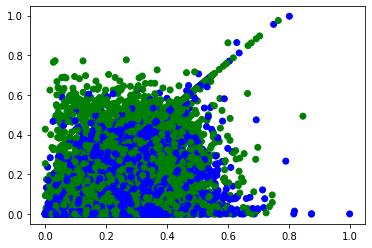

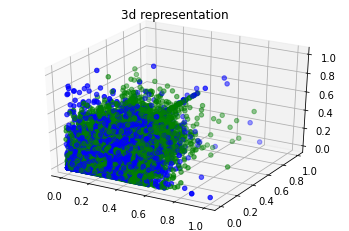

In [4]:
# path
train_sample=np.load('/content/Best_data/Train_data.npy')
train_label=np.load('/content/Best_data/Train_label.npy')
test_sample=np.load('/content/Best_data/Test_data.npy')
test_label=np.load('/content/Best_data/Test_label.npy')


# analisi
data_analize(train_sample,train_label,test_sample,test_label)

---

# **Riduzione delle dimensionalità PCA ed analisi dei dati ottenuti**

In [5]:
# centro dati
def center_data(data,mean):
  data_c = data - mean
  return data_c



# calcolo media sui dati
def calculate_mean(data):
  return np.mean(data,axis=0)



# calcolo trasformazione pca
def calculate_pca_transform(N,mean,sample):

  # centro i dati
  Xc = center_data(sample,mean)

  # calcolo la matrice di covarianza dei dati centrati
  C = np.cov(Xc, rowvar=False) 

  # calcolo autovalori e autovettori della matrice di covarianza
  lambdas,U = np.linalg.eigh(C)

  # ordino gli autovalori dal più grande al più piccolo
  best_eig_idxs = np.argsort(lambdas)[::-1]
  best_eig = lambdas[best_eig_idxs] #valori ordinati

  # faccio scree plot
  x_axes=np.arange(sample.shape[1])+1
  plt.plot(x_axes[:50], best_eig[:50], 'ro-', linewidth=2)
  plt.title('Scree Plot')
  plt.xlabel('Principal Component')
  plt.ylabel('Eigenvalue')
  plt.show()
  
  # costruzione matrice di trasformazione T: 
  best_U = U[:,best_eig_idxs]
  T = best_U[:,:N]
  return T



# applico trasformazione della PCA ai dati
def apply_pca(matrix,mean,data):
  # centro dati
  data_c=center_data(data,mean)
  res = np.dot(data_c, matrix)
  return res

Applying principal component analisys...


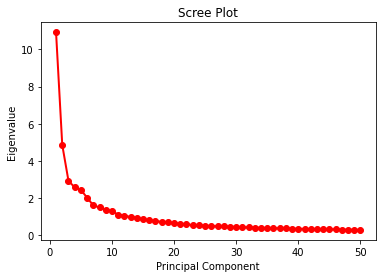


 Analyzing data...
TRAIN DATA

Train_sample composto da:
 -> 15096 oggetti
 -> 40 features per oggetto.

Train_label è un vettore di lunghezza: 15096


TEST DATA

Test_sample composto da:
 -> 2664 oggetti
 -> 40 features per oggetto.

Test_label è un vettore di lunghezza: 2664




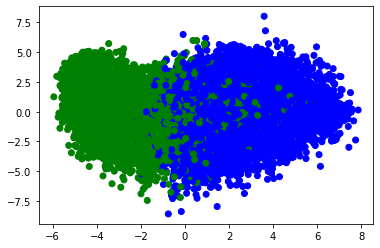

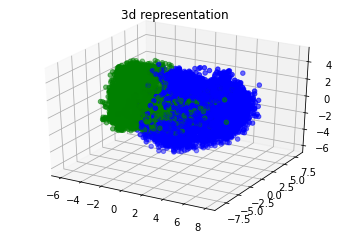

Done.


In [6]:
################################################################################
# Parametri PCA
pca_bool= True
n_components=40
################################################################################

# path of  directory
train_sample=np.load('/content/Best_data/Train_data.npy')
train_label=np.load('/content/Best_data/Train_label.npy')
test_sample=np.load('/content/Best_data/Test_data.npy')
test_label=np.load('/content/Best_data/Test_label.npy')
data=np.load('/content/Best_data/Data.npy')

# se richiesto, calcolo pca
if pca_bool==True:
  print('Applying principal component analisys...')

  # calcolo media e matrice di trasformazione 
  mean=calculate_mean(data)
  pca_matrix =calculate_pca_transform(n_components,mean,train_sample)

  # applico pca a train set
  train_sample = apply_pca(pca_matrix,mean,train_sample)

  # applico pca a test set
  test_sample = apply_pca(pca_matrix,mean,test_sample)
  print('\n Analyzing data...')
  data_analize(train_sample,train_label,test_sample,test_label)

else: # se non richiesta
  print('PCA not applied, data no changes.')

print('Done.')

---

# **Addestramento del classificatore**

**Classificatore 1: SVM**


```
                                        PCA components
             20      30      40      50      60       70      80     90      100     None  
  linear  | 97,3  | 98,2  | 98,09 | 98,84 | 98,76 | 98,69 | 98,76 | 98,8  | 98,87 | 98,72 |
  sigmoid | 93,21 | 93,99 | 94,29 | 94,82 | 95,83 | 95,98 | 96,47 | 96,36 | 96,43 | 88,51 |
  rbf     | 99,55 | 99,66 | 99,81 | 99,7  | 99,74 | 99,74 | 99,74 | 99,74 | 99,77 | 99,62 |
  poly 1  | 97,3  | 98,16 | 98,09 | 98,57 | 98,61 | 98,72 | 98,87 | 98,91 | 99,02 | 99,17 |
  poly 2  | 97,9  | 98,91 | 99,21 | 99,4  | 99,4  | 99,44 | 99,66 | 99,74 | 99,7  | 99,4  |
  poly 3  | 99,4  | 99,51 | 99,55 | 99,66 | 99,7  | 99,7  | 99,7  | 99,66 | 99,66 | 99,59 |
```



In [7]:
# addestramento SVM
def train_SVC(svc, X_train, Y_train):
    print('Training SVM with',X_train.shape[1],'features and rbf kernel')
    svc.fit(X_train, Y_train)
    return svc

# test del classificatore
def test_SVC(svc,X_test,Y_test):
  return round(svc.score(X_test,Y_test),4)

# matrice di confusione
def confusion_matrix(model, test_sample,test_label):
  cmc = np.zeros((2,2))
  predicted = model.predict(test_sample)
  for pred, label in zip(predicted,test_label):
    cmc[int(label),int(pred)] += 1.0

  plt.imshow(cmc)
  plt.colorbar()
  plt.xlabel("Predicted")
  plt.xticks([0,1],["no_vehicle","vehicle"])
  plt.yticks([0,1],["no_vehicle","vehicle"])
  plt.ylabel("Real")
  plt.show()

  # accuratezza
  accuracy = np.sum(cmc.diagonal())/np.sum(cmc)

  # precision
  precision_0 = cmc[0,0]/ np.sum(cmc[:,0])
  precision_1 = cmc[1,1]/ np.sum(cmc[:,1])

  # recall
  recall_0 = cmc[0,0]/ np.sum(cmc[0,:])
  recall_1 = cmc[1,1]/ np.sum(cmc[1,:])

  # stampa dei risultati
  print('Accuracy: ' + "{0:.2f}".format(accuracy*100) + '%')
  print('Precision relative to the class no_vehicle: ' + "{0:.2f}".format(precision_0))
  print('Precision relative to the class vehicle: ' + "{0:.2f}".format(precision_1))
  print('Recall relative to the class no_vehicle: ' + "{0:.2f}".format(recall_0))
  print('Recall relative to the class vehicle: ' + "{0:.2f}".format(recall_1))

  return cmc

Training SVM with 40 features and rbf kernel
SVM trained in  1 seconds.


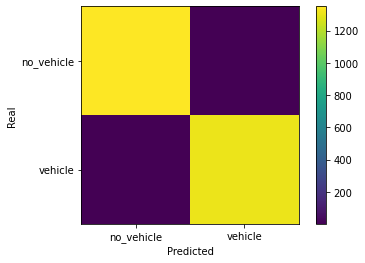

Accuracy: 99.81%
Precision relative to the class no_vehicle: 1.00
Precision relative to the class vehicle: 1.00
Recall relative to the class no_vehicle: 1.00
Recall relative to the class vehicle: 1.00


In [8]:
################################################################################
# Parametri
kernel='rbf'                    # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’}
degree=3                        # only with 'poly' kernel function
max_iter= -1                    # default -1
################################################################################
#https://scikit-learn.org/stable/modules/svm.html#svm

# creazione SVM
clf_svm = svm.SVC(kernel=kernel, degree=degree, max_iter=max_iter, decision_function_shape='ovr')

# addestramento
t1=time.time()
clf_svm= train_SVC(clf_svm,train_sample,train_label.ravel())
t2=time.time()
print('SVM trained in ',int(t2-t1),'seconds.')

# test classificatore
# matrix = plot_confusion_matrix(clf_svm, test_sample, test_label,cmap=plt.cm.Purples,normalize='true')
cmc=confusion_matrix(clf_svm,test_sample,test_label)

# salvataggio modello svm
pickle.dump(clf_svm, open('model_svm.pkl', 'wb'))

# print(cmc)

---

**Classificatore 2: KNN**



```
                                        PCA components
          20      30      40      50      60      70      80      90     100     None   
  K=1 | 99,59 | 99,62 | 99,62 | 99,74 | 99,77 | 99,77 | 99,77 | 99,74 | 99,74 | 99,29 |
  K=2 | 99,51 | 99,66 | 99,7  | 99,81 | 99,77 | 99,74 | 99,77 | 99,66 | 99,55 | 98,5  |
  K=3 | 99,7  | 99,85 | 99,77 | 99,77 | 99,81 | 99,77 | 99,77 | 99,81 | 99,7  | 98,99 |
  K=4 | 99,62 | 99,77 | 99,85 | 99,81 | 9985  | 99,81 | 99,81 | 99,81 | 99,77 | 98,35 |
  K=5 | 99,74 | 99,81 | 99,85 | 99,85 | 99,74 | 99,85 | 99,89 | 99,81 | 99,81 | 98,65 |
  K=6 | 99,89 | 99,81 | 99,89 | 9989  | 99,81 | 99,85 | 99,85 | 99,85 | 99,85 | 98,27 |
```






Training KNN with 20 features.
KNN trained in  0 seconds.


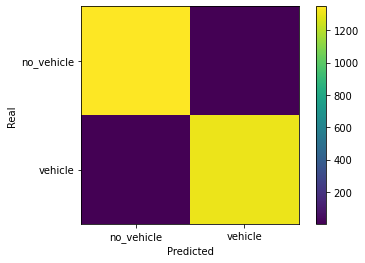

Accuracy: 99.89%
Precision relative to the class no_vehicle: 1.00
Precision relative to the class vehicle: 1.00
Recall relative to the class no_vehicle: 1.00
Recall relative to the class vehicle: 1.00


In [ ]:
################################################################################
# Parametri KNN
n_neig=6                # neighbors
p=2                     # euclidean distance
################################################################################
#https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

# istanziazione modello KNN
clf_knn=KNeighborsClassifier(n_neighbors=n_neig,p=p)

# train
print('Training KNN with',train_sample.shape[1],'features.')
t1=time.time()
clf_knn.fit(train_sample,train_label)
t2=time.time()
print('KNN trained in ',int(t2-t1),'seconds.')

# test modello KNN
cmc=confusion_matrix(clf_knn,test_sample,test_label)

# salvataggio modello KNN
pickle.dump(clf_knn, open('model_knn.pkl', 'wb'))
# print(cmc)

---

# **Object Detection**

In [ ]:
# cambia spazio colore all'immagine
def change_color_space(img,n_color):
  if n_color==1:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
  elif n_color==2:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
  elif n_color==3:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2LUV)
  elif n_color==4:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
  elif n_color==5:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2YUV)
  elif n_color==6:
    img=cv2.cvtColor(img,cv2.COLOR_BGR2YCrCb)
  
  return img


# define the sliding window:
def sliding_window(image, stepSize, windowSize):
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y: y + windowSize[1], x:x + windowSize[0]])



# ritorna predizione dal classificatore
def get_prediction(fd,clf_number):
  label=None
  if clf_number==1:#svm
    label=clf_svm.predict(fd)
  elif clf_number==2: #knn
    label=clf_knn.predict(fd)
  else:#usa comunque svm 
    label=clf_svm.predict(fd)
  
  return label


# estrai hog features
def extract_hog_features(img,orientations,pixels_per_cell,cells_per_block):
  hog_feat=[]
  # per ogni canale di colore dell'immagine
  for ch in range(img.shape[2]):
    # ricavo vettore delle caratteristiche dal ch-esimo canale
    fd=hog(img[:,:,ch],orientations=orientations,pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block,visualize=False,transform_sqrt=True,feature_vector=True)
    #aggiungo alla lista
    hog_feat.append(fd)
  return np.ravel(hog_feat)


def elaborate(im_path,X_scaler,clf_number,color):
  # carico immagine
  img= cv2.imread(im_path)
  original=img
  found=0
  # dimenisone sliding windoow
  (winW, winH)= (156,156)
  windowSize=(winW,winH)
  downscale=1.5
  scale=0
  detections=[]
  #cv2_imshow(original)

  # preparo immagine
  img=change_color_space(img,color)

  # calcolo nuovo punto di partenza e arrivo delle coordinate x
  x_start=780
  img=img[x_start:(img.shape[0]-100)][:] 

  # applica sliding window:
  for resized in pyramid_gaussian(img, downscale=downscale): # loop over each layer of the image that you take!1.5
      # loop
      for (x,y,window) in sliding_window(resized, stepSize=100, windowSize=(winW,winH)):
          # controllo che le dimensioni finestra siano quelle desiderate
          if window.shape[0] == winH and window.shape[1] ==winW and window.shape[2]==3: 
           window_r = cv2.resize(window,(64,64))
           # estraggo features da window
           fd=extract_hog_features(window_r,orientations=9,pixels_per_cell=(8,8),cells_per_block=(2,2)) 
           fd=fd.reshape(1, -1)
            # normalizzo
           fd=X_scaler.transform(fd)
           # applico pca se richiesto
           if pca_bool==True:
            fd= apply_pca(pca_matrix,mean,fd)
           # verifico se presente auto
           pred=get_prediction(fd,clf_number)
           if pred==1: # trovata
            found=1
            detections.append((int(x * (downscale**scale)), int(y * (downscale**scale)),int(windowSize[0]*(downscale**scale)),int(windowSize[1]*(downscale**scale))))  
           else:
             continue


  clone = resized.copy()
  original1=original.copy()
  for (x_tl, y_tl, w, h) in detections:
     cv2.rectangle(original1, (x_tl, x_start+y_tl), (x_tl + w, x_start+y_tl + h), (0, 255, 0), thickness = 2)
  rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in detections]) 
  #print('image with no maximum_suppression')

  if found==1:
    # applico no_maximum_suppression
    #https://www.pyimagesearch.com/2014/11/17/non-maximum-suppression-object-detection-python/
    bounded_boxes = non_max_suppression(rects, overlapThresh = 0.3)
    for (xA, yA, xB, yB) in bounded_boxes:
        cv2.rectangle(original, (xA, x_start+yA), (xB, x_start+yB), (0,255,0), 2)
  cv2_imshow(original)



    

In [ ]:
################################################################################
# parametri
clf_number=1 # 1:svm, 2:knn
color=6
################################################################################

# carica lo scaler
X_scaler=pickle.load(open('/content/Best_data/scaler.pkl', 'rb'))

# per ogni file presente nella cartella test_images
for im_path in glob.glob(os.path.join('/content/test_images', "*")):
  tf1=time.time()
  print(im_path)
  # processa immagine corrente
  elaborate(im_path=im_path,X_scaler=X_scaler,clf_number=clf_number,color=color)
  tf2=time.time()
  print('elaborated in',round((tf2-tf1),2),'seconds.')
print('Done.')

Output hidden; open in https://colab.research.google.com to view.

---